In [2]:
###############################################################################
# 
# author: Jonathan Fisher
#         j.fisher@fz-juelich.de
#         jonathan.m.fisher@gmail.com
#
# description:
#     generates (obviously fake) simulated biodiff data,
#  with and without slowly varying background. This is used
#  in functional tests of nsxlib.
#
###############################################################################

import numpy as np
import math
import pynsx as nsx
import h5py

pi2 = np.pi / 2.0
wavelength = 2.67
dmin = 1.5
dmax = 50.0
infile = "/home/jonathan/git/nsxtool/tests/data/blank.hdf"
outfile = "/home/jonathan/git/nsxtool/tests/data/simulated.hdf"

group_name = "P 21 21 21"
#group_name = "P 1"
group = nsx.SpaceGroup(group_name)

from matplotlib import pyplot as plt

def correct_image(image):
    baseline = 227.0
    gain = 8.0
    return gain*(image+baseline)

def poisson_noise(image):
    return np.sqrt(image)*np.random.normal(0, 1, image.shape)

exp = nsx.Experiment("Simulated", "BioDiff2500")
diff = exp.getDiffractometer()
reader = nsx.HDF5DataReader(infile, diff)
data = nsx.DataSet(reader, diff)
exp.addData(data)

A = np.diag([43., 53., 61.])
U = np.random.rand(3,3)
U = np.identity(3) + U.dot(U.transpose())
_, U = np.linalg.eig(U)

uc = nsx.UnitCell(U.dot(A))
ch = nsx.CellCharacter(uc.metric())
print(ch.a, ch.b, ch.c)
uc.niggliBasis()

uc.setSpaceGroup(group_name)

det_shape = nsx.Ellipsoid(np.array([800.0, 450.0, 10.0]), 5.0)
peak = nsx.Peak3D(data, det_shape)
peak.setSelected(True)

hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)
len(hkls)

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


43.0 52.99999999999999 61.00000000000001


172542

In [57]:
print(data.nFrames())

166


In [3]:
qs = nsx.ReciprocalVectorList()
B = uc.reciprocalBasis()

for hkl in hkls:
    q = hkl.rowVector().dot(B)
    qs.push_back(nsx.ReciprocalVector(q))

In [4]:
events = data.getEvents(qs)
len(events)

27741

In [5]:
sigmaD = 0.3
sigmaM = 0.2

peaks = []

for event in events:
    center = np.array([event._px, event._py, event._frame])
    peak = nsx.Peak3D(data, nsx.Ellipsoid(center, 5.0))
    coords = nsx.PeakCoordinateSystem(peak)
    shape = coords.detectorShape(sigmaD, sigmaM)
    peak.setShape(shape)
    peaks.append(peak)

In [6]:
A = np.random.rand(3,3)
A /= np.linalg.norm(A)
A = 0.5*np.identity(3) + A.dot(A.transpose())
A /= np.linalg.norm(A)
A *= 50


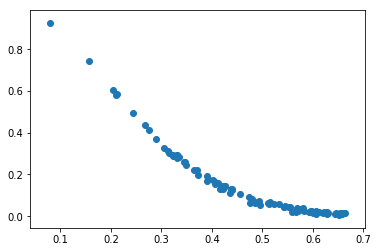

In [7]:
import random
from matplotlib import pyplot as plt

qs = []
Is = []

for i in range(100):
    peak = random.sample(peaks, 1)[0]
    q = peak.q().rowVector()
    qs.append(np.linalg.norm(q))
    
    new_I = 0
    
    elements = group.groupElements()
    for el in elements:
        g = el.getRotationPart()
        gq = q.dot(g)
        new_I += np.exp(-gq.dot(A).dot(gq.transpose()).trace() / 2.0)
        
    I = new_I / len(elements)    
    Is.append(I)
    #print(I)
       
        
plt.scatter(qs, Is)
plt.show()

In [63]:
np.linalg.eig(A)

(array([44.26113047, 15.59901229, 17.25175774]),
 array([[ 0.64796849,  0.75052638, -0.12979594],
        [ 0.70697626, -0.6560528 , -0.26415769],
        [ 0.2834103 , -0.07940321,  0.95570588]]))

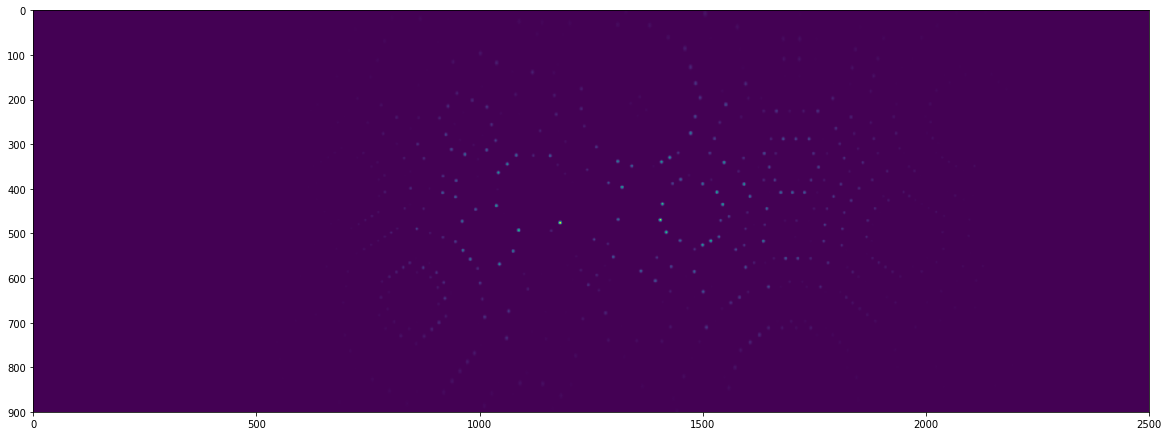

In [46]:
def frame_peaks(idx, peaks, nsigma):
    in_frame = []
    
    for peak in peaks:
        center = peak.getShape().center()
        extents = peak.getShape().aabb().extents()
        
        df = extents[2] / 2.0
        
        if abs(center[2]-idx) > nsigma*df:
            continue
            
        in_frame.append(peak)
        
    return in_frame

def generate_frames(peaks, fmin, fmax):
    Imax = 200**2
    nsigma = 4    
    rows, cols = data.frame(0).shape
    image = np.zeros(shape=(rows, cols, fmax-fmin), dtype=np.float)
    
    B = uc.reciprocalBasis()
    BI = np.linalg.inv(B)
       
    #in_frame = frame_peaks(idx, peaks, nsigma)
    #print(len(in_frame))
    elements = group.groupElements()
    gs = [ B.dot(el.getRotationPart()).dot(BI) for el in elements ]
    
    for peak in peaks:
        #print("#######################################")
        
        
        aabb = peak.getShape().aabb()
        shape = peak.getShape()
        center = shape.center()
        inv_cov = shape.metric()
        extents = aabb.extents()
        
        I = 0        
        q = peak.q().rowVector().transpose()        
        
        for g in gs:
            gq = g.dot(q)
            I += Imax * np.exp(-0.5*gq.transpose().dot(A).dot(gq).trace())
            
        I /= len(gs)
        #print("intensity", I)
        
        xmin = int(center[0,0] - nsigma*extents[0,0]/2)
        xmax = int(center[0,0] + nsigma*extents[0,0]/2)
        
        ymin = int(center[1,0] - nsigma*extents[1,0]/2)
        ymax = int(center[1,0] + nsigma*extents[1,0]/2)
        
        zmin = int(center[2,0] - nsigma*extents[2,0]/2)
        zmax = int(center[2,0] + nsigma*extents[2,0]/2)
        
        xmin = max(0, xmin)
        xmax = min(data.nCols(), xmax)
        
        ymin = max(0, ymin)
        ymax = min(data.nRows(), ymax)
        
        #print("z0", zmin, zmax)
        
        zmin = max(fmin, zmin)
        zmax = min(fmax, zmax)
        
        #print("x", xmin, xmax)
        #print("y", ymin, ymax)
        #print("z", zmin, zmax)       
        
        x = range(xmin, xmax)
        y = range(ymin, ymax)
        z = range(zmin, zmax)
        
        if xmin >= xmax or ymin >= ymax or zmin >= zmax:
            continue
               
        #print("x:", x)
        #print("y:", y)
        
        #print("dx:", np.array(x)-center[0,0])
        #print("dy:", np.array(y)-center[1,0])
        
        x, y, z = np.meshgrid(x, y, z)
                
        dx = x-center[0,0]
        dy = y-center[1,0]
        dz = z-center[2,0]
        
        
        #print("dx", dx.transpose())
        
        M = shape.metric()
        #print(M.shape)
        #print(dx.shape)
        #print(x.shape)
        arg = dx**2 * M[0,0] + dy**2 * M[1,1] + dz**2 * M[2,2]
        arg += 2*dx*dy*M[0,1] + 2*dx*dz*M[0,2] + 2*dy*dz*M[1,2]
               
        gauss = np.exp(-0.5*arg)
        gauss /= gauss.sum()
        
        inten = I * gauss
        #print("inten", inten.shape)
        #print("im", image.shape, image[ymin:ymax, xmin:xmax, (zmin-fmin):(zmax-fmin)].shape)
        #print("integrated intensity", inten.sum())
        #print("z", zmin, zmax)
        image[ymin:ymax, xmin:xmax, (zmin-fmin):(zmax-fmin)] += inten   
        
        
        
        #break
    
    return image

im = generate_frames(peaks, 45, 55)
plt.figure(figsize=(20,10))
plt.imshow(im[:, :, 5])
plt.show()

In [48]:
for el in group.groupElements():
    print(el.getRotationPart())

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0. -1.]]


In [49]:
indexer = nsx.AutoIndexer(nsx.ProgressHandler())


for peak in peaks:
    indexer.addPeak(peak)
    
indexer.autoIndex(param)

NameError: name 'param' is not defined

In [65]:
param = nsx.IndexerParameters()
param.maxdim = 100.0
param.minUnitCellVolume = 20*20*20
#param.nVertices = 1000

In [67]:
solns = indexer.getSolutions()

for sln in solns:
    fit_uc, score = sln
    ch = nsx.CellCharacter(fit_uc.metric())
    print(ch.a, ch.b, ch.c, score)

42.99999999999998 52.999999999999986 60.99999999999998 100.0
43.00000000000002 53.00000000000008 61.0000000000001 100.0
43.0 60.99999999999997 106.00000000000013 100.0
42.99999999999999 61.00000000000003 158.9999999999999 100.0
80.8084154033476 42.99999999999995 161.61683080669496 100.0
43.0 60.99999999999999 264.99999999999994 100.0
42.99999999999999 61.00000000000002 317.9999999999998 100.0
68.24954212300607 101.01980003939849 129.35609765295206 100.0
106.0 244.00000000000003 42.999999999999936 100.0
91.53687781435471 101.01980003939806 139.7927036722583 100.0
161.6168308066954 42.999999999999986 200.41207548448764 100.0
133.01503674397125 42.999999999999986 244.59762877019057 100.0
170.29973576021771 42.999999999999986 242.42524621004313 100.0
91.53687781435417 142.69547995644427 149.50919704151977 100.0
200.41207548448764 42.99999999999999 244.59762877019065 100.0
200.41207548448764 42.99999999999999 242.4252462100431 100.0
91.53687781435411 142.69547995644422 175.64452738414585 10

In [28]:
1 / -0.07142857142857166

-13.999999999999954

In [29]:
COB = np.linalg.inv(solns[3][0].basis()).dot(uc.basis())
print(COB)
1.0 / np.linalg.det(COB)

[[-1.00000000e+00 -9.76949528e-16 -4.86819600e-16]
 [ 5.99622992e-16 -1.00000000e+00 -5.12347376e-16]
 [ 2.38283080e-17 -3.18317438e-16  1.00000000e+00]]


1.0000000000000002

In [30]:
print(solns[0][0].niggliBasis())
print(solns[0][0].basis())

[[-22.29296442  42.37011306  18.51436166]
 [-28.78493286  -8.40467485 -44.2716129 ]
 [-22.8790598  -30.71050243  37.65956324]]
[[-22.29296442  42.37011306  18.51436166]
 [-28.78493286  -8.40467485 -44.2716129 ]
 [-22.8790598  -30.71050243  37.65956324]]


In [33]:
im.mean()

0.3300163618306957

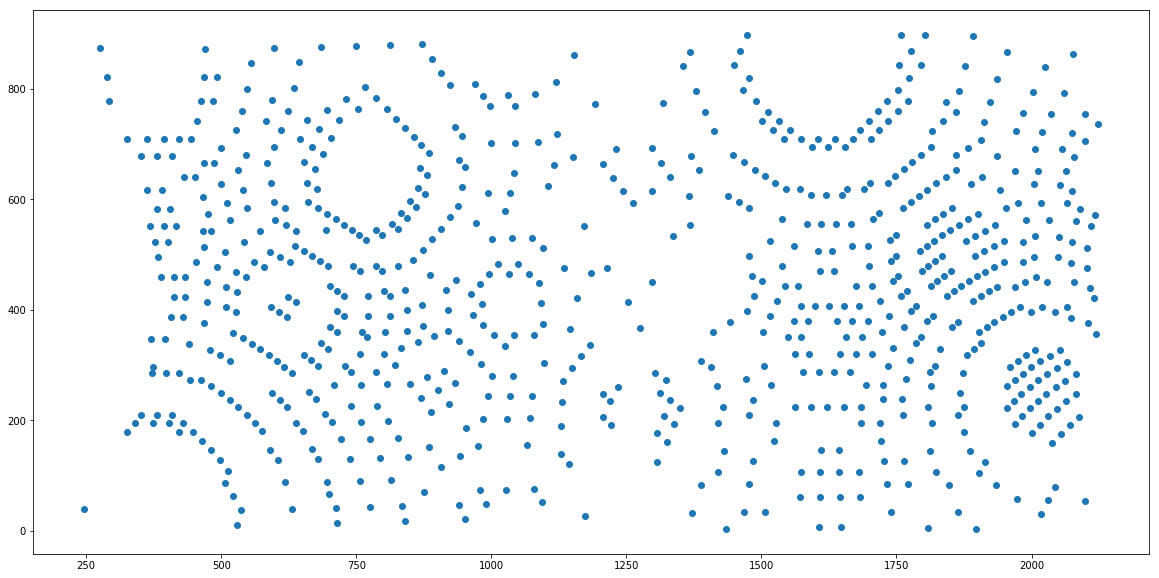

In [50]:
in_frame = frame_peaks(10, peaks, 3)

xs = []
ys = []

for peak in in_frame:
    c = peak.getShape().center()
    xs.append(c[0,0])
    ys.append(c[1,0])

plt.figure(figsize=(20,10))
plt.scatter(xs, ys)
plt.show()

In [51]:
bkg = 40
noise = poisson_noise(bkg+im)
plt.figure(figsize=(20,10))
plt.imshow((bkg+im+noise)[300:600,950:1550])
plt.show()

TypeError: Invalid dimensions for image data

In [75]:
noise.std()

6.359321521098879

In [76]:
im.mean()

0.4874444298900754

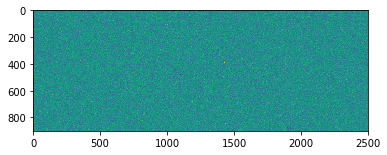

In [77]:
plt.imshow(noise)
plt.show()

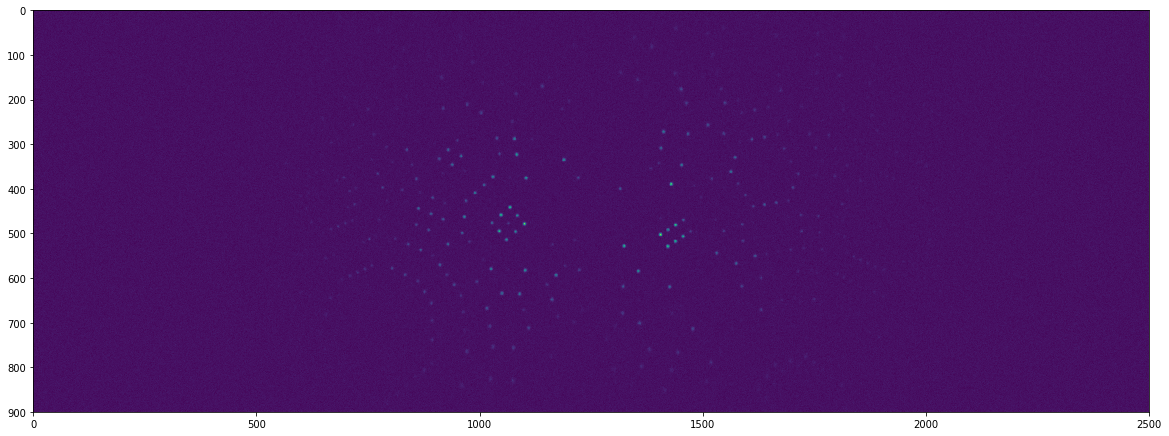

In [78]:
simulated = correct_image(bkg + noise + im)
plt.figure(figsize=(20,10))
plt.imshow(simulated)
plt.show()

In [52]:
def background():
    return 40.0

In [53]:
N = data.nFrames()
#N = 5
delta = 0.3 # hard coded!!

with h5py.File(outfile, "w") as f:
    data_grp = f.create_group("Data")
    scan = f.create_group("Data/Scan")
    expr = f.create_group("Experiment")
    info = f.create_group("Info")
    
    images = data_grp.create_dataset("Counts", (N, 900, 2500,), dtype='i4', compression="gzip", compression_opts=9)
    
    scan.create_dataset("Sample/chi", (N,), dtype="f8")
    omega = scan.create_dataset("Sample/omega", (N,), dtype="f8")
    scan.create_dataset("Sample/phi", (N,), dtype="f8")
    
    scan.create_dataset("Source/chi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/om-mono", (N,), dtype="f8")
    scan.create_dataset("Source/phi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/x-mono", (N,), dtype="f8")
    scan.create_dataset("Source/y-mono", (N,), dtype="f8")
    
    scan.create_dataset("Detector/2theta(gamma)", (N,), dtype="f8")
    
    expr.attrs.create("npdone", N, dtype="i4")
    expr.attrs.create("monitor", 0.0)
    expr.attrs.create("wavelength", 2.67)
    expr.attrs.create("Numor", 0, dtype="i4")
  
    info.attrs.create("Instrument", b"BioDiff2500")
    
       
    bkg = background()
    simulated = generate_frames(peaks, 0, N)
        
    for i in range(N):        
    #for i in range(10):        
        #simulated = generate_frame(i, peaks) + bkg
        sim = simulated[:, :, i]
        noise = poisson_noise(sim)        
        sim += noise
        sim = correct_image(sim)
        images[i] = sim
        omega[i] = i*delta
        
        print(i, images[i].mean())
        
            
    f.flush()
    f.close()
    
print("Done simulating data.")

0 1818.3968755555557
1 1820.0617413333334
2 1820.2488026666667
3 1819.9485564444444
4 1819.8883608888889
5 1819.7384915555556
6 1819.7858808888889
7 1819.7319164444446
8 1819.6295764444444
9 1819.502456888889
10 1819.4863271111112
11 1819.6694706666667
12 1819.9817244444444
13 1820.2136751111111
14 1820.0913595555555
15 1820.0037253333333
16 1819.7884404444444
17 1819.7501115555556
18 1819.5606337777779
19 1819.792252888889
20 1819.6916484444444
21 1819.9467506666667
22 1820.213368
23 1820.0745346666668
24 1819.9779426666666
25 1819.822196
26 1819.8498804444444
27 1819.71728
28 1819.5032146666667
29 1819.4409813333334
30 1819.7279035555555
31 1820.2325804444445
32 1820.1232862222223
33 1819.8841217777779
34 1819.6540755555557
35 1819.6219808888889
36 1819.6801186666667
37 1819.6188813333333
38 1819.596544
39 1819.8276626666666
40 1819.9406613333333
41 1819.7553746666667
42 1819.7475035555556
43 1819.9704857777779
44 1820.0324915555555
45 1819.934703111111
46 1819.6246808888889
47 1819.

In [81]:
print(42)

42


In [52]:
help(h5py.File)

Help on class File in module h5py._hl.files:

class File(h5py._hl.group.Group)
 |  Represents an HDF5 file.
 |  
 |  Method resolution order:
 |      File
 |      h5py._hl.group.Group
 |      h5py._hl.base.HLObject
 |      h5py._hl.base.CommonStateObject
 |      h5py._hl.base.MutableMappingHDF5
 |      h5py._hl.base.MappingHDF5
 |      collections.abc.MutableMapping
 |      collections.abc.Mapping
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __init__(self, name, mode=None, driver=None, libver=None, userblock_size=None, swmr=False, **kwds)
 |      Create a new file object.
 |      
 |      See the h5py user guide for a detailed explanation of the options.
 |      
 |      name
 |          Name of the file on disk.  Note: for files created with the 'core'
 |          driver, HDF5 stil

In [35]:
simulated = generate_frames(peaks, 0, N)

In [36]:
simulated.shape

(900, 2500, 166)

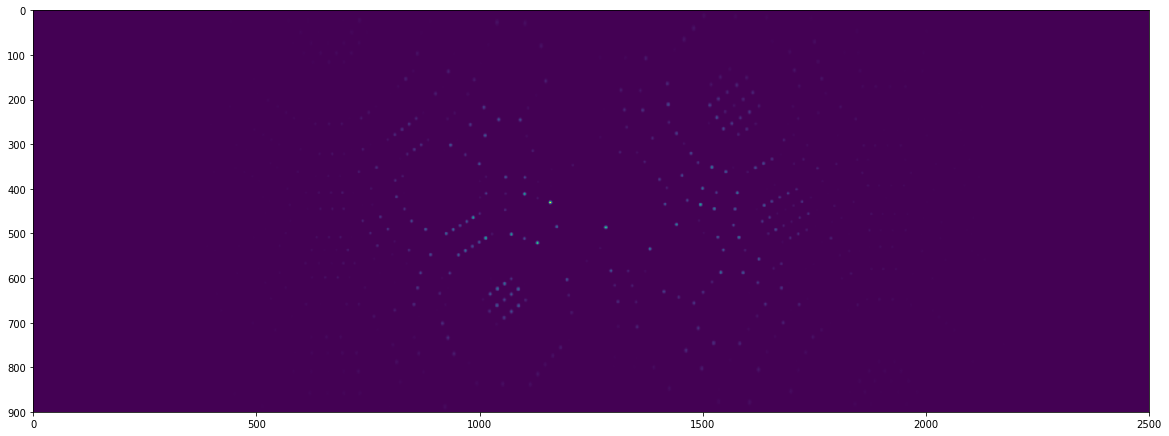

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(simulated[:,:,150])
plt.show()